# 知識點
幾何轉換對於電腦視覺的意義除了增加資料量 (Augmentation) 以外，還常常應用在架構上的設計或是前、後處理：
- 透過縮放做 upsample / downsample
- 透過 affine transform 做匹配處理
- 透過 perspective transform 做對齊處理

## 水平、垂直翻轉 (Flip) 
其實只是將 x、y 軸順序顛倒，例如垂直翻轉就是把與 x 軸平行的值順序顛倒，也就是 `img[::-1, :, :]`

In [1]:
import cv2
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.rc('figure', figsize=(10, 8))

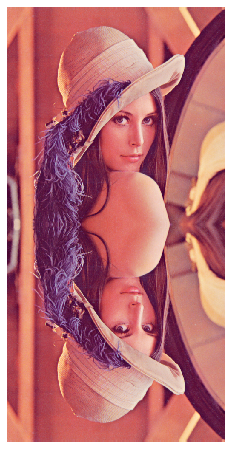

In [2]:
img = cv2.imread('lena.png', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 垂直翻轉 (vertical)
img_vflip = img[::-1, :, :]

# 組合 + 顯示圖片
vflip = np.vstack((img, img_vflip))
plt.axis('off')
plt.imshow(vflip);

## 縮放操作
使用 OpenCV 內建的函式操作 `cv2.resize(img, new_shape, fx, fy, interpolation)`

其中 `fx, fy` 為兩軸的縮放比例，與 `new_shape` 擇一使用就好。

縮放的處理方式 (`interpolation`) 會影響處理的速度與圖片品質：
- cv2.INTER_NEAREST: 最鄰近插點法
- cv2.INTER_LINEAR: 雙線性插補(預設)，在電腦視覺領域是特別常用。<br>
    雖然像素是離散值，但是雙線性會參考周遭 4 個點，根據目標位置到 4 個點的距離當作權重，因此這樣處理的圖片比較不會產生鋸齒狀邊緣。<br>
    請參考 [Nearest Neighbor and Bilinear Interpolation](https://jason-chen-1992.weebly.com/home/nearest-neighbor-and-bilinear-interpolation)
- cv2.INTER_AREA: 臨域像素再取樣插補
- cv2.INTER_CUBIC: 雙立方插補，4×4大小的補點
- cv2.INTER_LANCZOS4: Lanczos插補，8×8大小的補點

這是因為縮小跟放大要參考周圍的 pixel 值，然後藉由統計與運算去減少/生成新的 pixel 值。
- 放大建議用 INTER_CUBIC (slow) 或是 INTER_LINEAR。
- 縮小建議用 INTER_AREA。

INTER_NEAREST zoom cost 0.04817056655883789
INTER_LINEAR zoom cost 0.0016345977783203125


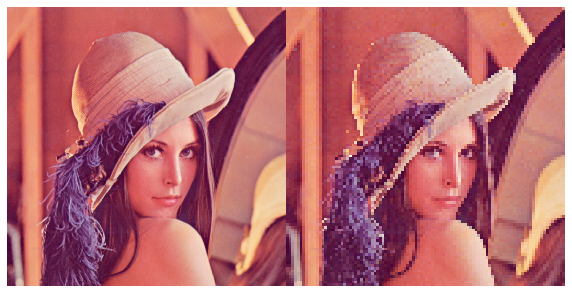

In [3]:
# 將圖片縮小成原本的 20%
img_test = cv2.resize(img, None, fx=0.2, fy=0.2)

# 將圖片放大為"小圖片"的 8 倍大 = 原圖的 1.6 倍大
fx, fy = 8, 8

# 鄰近差值 scale + 計算花費時間
start_time = time.time()
img_area_scale = cv2.resize(img_test, None, fx=fx, fy=fy, interpolation=cv2.INTER_NEAREST)
print(f'INTER_NEAREST zoom cost {time.time() - start_time}')

# 組合 + 顯示圖片
start_time = time.time()
orig_img = cv2.resize(img, img_area_scale.shape[:2]) # 使用預設 INTER_LINEAR
print(f'INTER_LINEAR zoom cost {time.time() - start_time}')
img_zoom = np.hstack((orig_img, img_area_scale))
plt.axis('off')
plt.imshow(img_zoom);

## 平移操作 (Translation Transformation)

平移為物體往某個向量方向移動，但是形狀、結構與視角都不發生改變，主要有兩種方法：
- 法一：手動做 xy 軸的四則運算取得移動後的位置 (慢)
- 法二：以矩陣運算方式操作 (快)
    - 圖片與 Transformation Matrix 相乘，一次性操作就可以得到平移後的值。<br>
    原理請參考 [transform的matrix屬性](https://ithelp.ithome.com.tw/articles/10197360)

實作可以使用 `cv2.warpAffine(img, Matrix, (column, row))`

當我們給定不一樣的 Matrix 就可以做不一樣的 Transformation，因此可以透過 np.array 產生平移矩陣後再經由 warpAffine 產生平移後圖片。


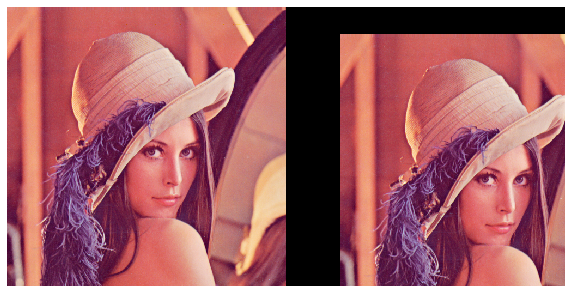

In [4]:
# 設定 translation transformation matrix
# x 平移 100 pixel; y 平移 50 pixel
M = np.array([[1, 0, 100],
              [0, 1, 50]], dtype=np.float32)
shift_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

# 組合 + 顯示圖片
img_shift = np.hstack((img, shift_img))
plt.axis('off')
plt.imshow(img_shift);

# 作業

實作本篇提到的三大概念

- 翻轉：實作上下左右的翻轉
- 縮放：比較鄰近差值與雙立方插值 (或雙線性插值) 的圖片品質
- 平移：建立 Translation Transformation Matrix 來做平移

## 上下左右翻轉圖片

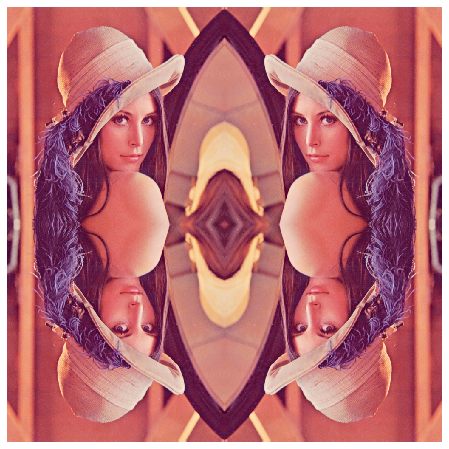

In [5]:
# 水平翻轉 (horizontal)
img_hflip = img[:, ::-1, :]

# 垂直翻轉 (vertical)
img_vflip = img[::-1, ...]

# 水平 + 垂直翻轉
img_hvflip = img[::-1, ::-1, :]

# 組合 + 顯示圖片
hflip = np.hstack((img, img_hflip))
vflip = np.hstack((img_vflip, img_hvflip))
img_flip = np.vstack((hflip, vflip))
plt.axis('off')
plt.imshow(img_flip);

## 縮放圖片

### 放大

我們先透過縮小圖片去壓縮原有圖片保有的資訊，再放大比較不同方法之間的速度與圖片品質

INTER_NEAREST zoom cost 0.0011720657348632812
INTER_CUBIC zoom cost 0.37058210372924805


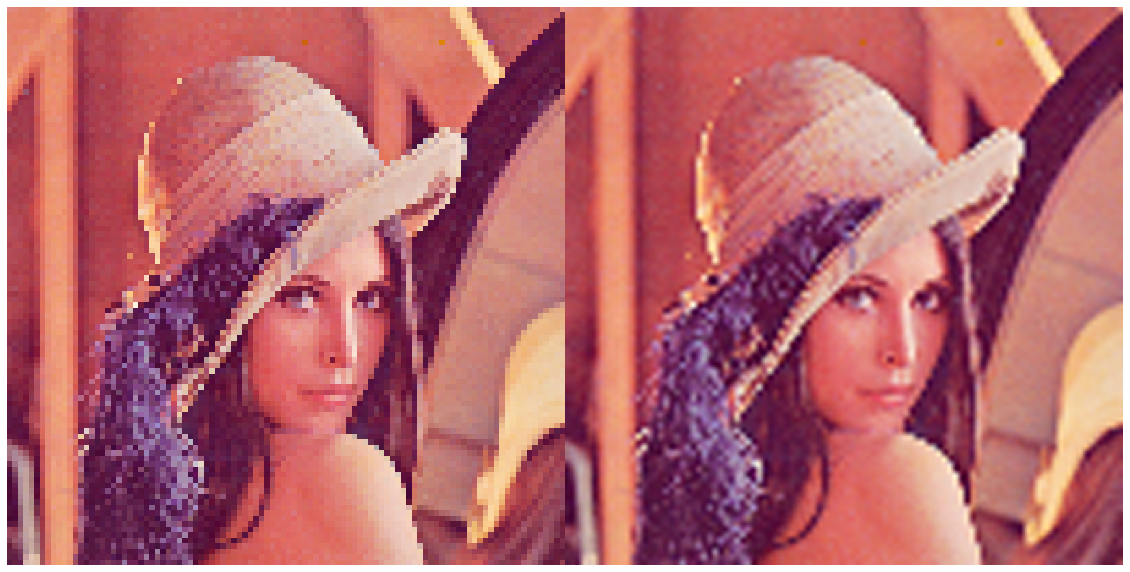

In [6]:
# 將圖片縮小成原本的 20%
img_test = cv2.resize(img, None, fx=0.2, fy=0.2)

# 將圖片放大為"小圖片"的 8 倍大 = 原圖的 1.6 倍大
fx, fy = 8, 8

# 鄰近差值 scale + 計算花費時間
start_time = time.time()
img_area_scale = cv2.resize(img_test, None, fx=fx, fy=fy, interpolation=cv2.INTER_NEAREST)
print('INTER_NEAREST zoom cost {}'.format(time.time() - start_time))

# 雙立方差補 scale + 計算花費時間
start_time = time.time()
img_cubic_scale = cv2.resize(img_test, None, fx=fx, fy=fy, interpolation=cv2.INTER_CUBIC)
print('INTER_CUBIC zoom cost {}'.format(time.time() - start_time))

# 組合 + 顯示圖片
img_zoom = np.hstack((img_area_scale, img_cubic_scale))
plt.figure(figsize=(20, 18))
plt.axis('off')
plt.imshow(img_zoom);

## 平移幾何轉換

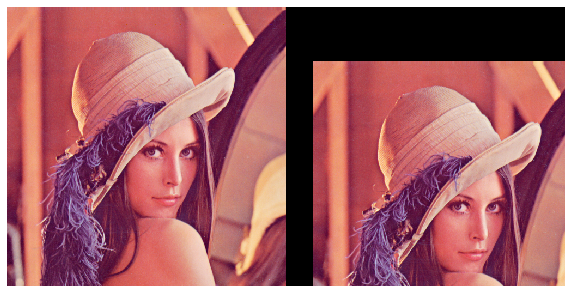

In [7]:
# 設定 translation transformation matrix
# x 平移 50 pixel; y 平移 100 pixel
M = np.array([[1, 0, 50],
              [0, 1, 100]], dtype=np.float32)
shift_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

# 組合 + 顯示圖片
img_shift = np.hstack((img, shift_img))
plt.axis('off')
plt.imshow(img_shift);

# 延伸閱讀
[演算法筆記 — 多項式內插](http://web.ntnu.edu.tw/~algo/Interpolation.html)